# Gender prediction at a session level using unstructured e-commerce cart data

In [1]:
# Import necessary modules modules

import os as os
import datetime as dt
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import re
# from pyzipcode import ZipCodeDatabase
from scipy import optimize

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, confusion_matrix, recall_score, f1_score, roc_curve
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import category_encoders as ce

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pickle

from keras.models import *
from keras.layers import *

Using TensorFlow backend.


In [2]:
train = pd.read_csv(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\train_8wry4cB.csv')
test = pd.read_csv(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\test_Yix80N0.csv')

In [3]:
df_train =  train.copy()
df_test =  test.copy()

In [8]:
df_train.shape , df_test.shape

((10500, 5), (4500, 4))

In [9]:
df_train.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male


In [10]:
# This is only for prediction (no label present)
df_test.head()

,session_id,startTime,endTime,ProductList
0,u12112,08/12/14 13:36,08/12/14 13:36,A00002/B00003/C00006/D19956/
1,u19725,19/12/14 13:52,19/12/14 13:52,A00002/B00005/C00067/D02026/
2,u11795,01/12/14 10:44,01/12/14 10:44,A00002/B00002/C00004/D12538/
3,u22639,08/12/14 20:19,08/12/14 20:22,A00002/B00003/C00079/D22781/;A00002/B00003/C00...
4,u18034,15/12/14 19:33,15/12/14 19:33,A00002/B00001/C00010/D23419/


In [19]:
df_train.set_index('session_id', inplace=True)

In [137]:
df_train.info()
# No missing values in the data

<class 'pandas.core.frame.DataFrame'>
Index: 10500 entries, u16159 to u23137
Data columns (total 71 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   startTime           10500 non-null  object        
 1   endTime             10500 non-null  object        
 2   ProductList         10500 non-null  object        
 3   gender              10500 non-null  object        
 4   start_time_DT       10500 non-null  datetime64[ns]
 5   end_time_DT         10500 non-null  datetime64[ns]
 6   duration_mins       10500 non-null  float64       
 7   Start_Time          10500 non-null  object        
 8   session_start_hour  10500 non-null  int64         
 9   Num_prods           10500 non-null  int64         
 10  Prods               10500 non-null  object        
 11  Prods_detail_1      10500 non-null  object        
 12  Prods_detail_2      10500 non-null  object        
 13  Prods_detail_3      10500 non-null  object   

In [138]:
# Exploring the dependent variable (prediction label)
df_train['gender'].describe()

# 8192 females & 2308 males (~20%) - Let's frame the lables so that males as 1 & females as 0

count      10500
unique         2
top       female
freq        8192
Name: gender, dtype: object

In [14]:
df_train['start_time_DT'] = pd.to_datetime(df_train['startTime'])
df_train['end_time_DT'] = pd.to_datetime(df_train['endTime'])

In [61]:
# Calculating session duration in minutes
df_train['duration_mins'] = (df_train['end_time_DT'] - df_train['start_time_DT'])/dt.timedelta(minutes=1)
df_train['Start_Time'] = [dt.datetime.time(d) for d in df_train['start_time_DT']]
df_train['session_start_hour'] = pd.to_datetime(df_train['Start_Time'], format='%H:%M:%S').dt.hour
df_train.head()

,startTime,endTime,ProductList,gender,start_time_DT,end_time_DT,duration_mins,Start_Time,session_start_hour
session_id,,,,,,,,,
u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,2014-12-15 18:11:00,2014-12-15 18:12:00,1.0,18:11:00,18
u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male,2014-12-16 14:35:00,2014-12-16 14:41:00,6.0,14:35:00,14
u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female,2014-01-12 15:58:00,2014-01-12 15:58:00,0.0,15:58:00,15
u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female,2014-11-23 02:57:00,2014-11-23 03:00:00,3.0,02:57:00,2
u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male,2014-12-17 16:44:00,2014-12-17 16:46:00,2.0,16:44:00,16


# Extract more features from the cart data

In [103]:
df_train['ProductList'] = df_train['ProductList'].apply(str) + ';'
df_train['Num_prods'] = df_train['ProductList'].apply(lambda x:len(re.findall(';', x)))
df_train.head(5)

,startTime,endTime,ProductList,gender,start_time_DT,end_time_DT,duration_mins,Start_Time,session_start_hour,Num_prods
session_id,,,,,,,,,,
u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,2014-12-15 18:11:00,2014-12-15 18:12:00,1.0,18:11:00,18,4
u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male,2014-12-16 14:35:00,2014-12-16 14:41:00,6.0,14:35:00,14,7
u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/;,female,2014-01-12 15:58:00,2014-01-12 15:58:00,0.0,15:58:00,15,1
u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female,2014-11-23 02:57:00,2014-11-23 03:00:00,3.0,02:57:00,2,3
u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male,2014-12-17 16:44:00,2014-12-17 16:46:00,2.0,16:44:00,16,2


In [104]:
df_train['Prods'] = df_train['ProductList'].apply(lambda x:re.split(';', x))
df_train.head(5)

,startTime,endTime,ProductList,gender,start_time_DT,end_time_DT,duration_mins,Start_Time,session_start_hour,Num_prods,Prods
session_id,,,,,,,,,,,
u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,2014-12-15 18:11:00,2014-12-15 18:12:00,1.0,18:11:00,18,4,"[A00002/B00003/C00006/D28435/, A00002/B00003/C..."
u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male,2014-12-16 14:35:00,2014-12-16 14:41:00,6.0,14:35:00,14,7,"[A00001/B00009/C00031/D29404/, A00001/B00009/C..."
u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/;,female,2014-01-12 15:58:00,2014-01-12 15:58:00,0.0,15:58:00,15,1,"[A00002/B00001/C00020/D16944/, ]"
u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female,2014-11-23 02:57:00,2014-11-23 03:00:00,3.0,02:57:00,2,3,"[A00002/B00004/C00018/D10284/, A00002/B00004/C..."
u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male,2014-12-17 16:44:00,2014-12-17 16:46:00,2.0,16:44:00,16,2,"[A00001/B00001/C00012/D30805/, A00001/B00001/C..."


In [105]:
"""
According to train data, Maximum num of products visited in a single session 36
99% of the sessions have 12 or less product visits
"""

df_train['Num_prods'].describe(percentiles=[0.01, 0.05, 0.1, 0.9, 0.95, 0.99])

count    10500.000000
mean         2.214381
std          2.311911
min          1.000000
1%           1.000000
5%           1.000000
10%          1.000000
50%          1.000000
90%          4.000000
95%          6.000000
99%         12.000000
max         36.000000
Name: Num_prods, dtype: float64

In [ ]:
"""
So, we are only going to use max 12 product items to predict the gender. If the num products visited in unseen data is > 12, 
we will only use the first 12 product details to predict (this truncation of information can be interpreted as outlier treatment)
"""

In [106]:
# Create columns for each of the 12 products
for i in range(12):
    colnam = 'Prods_detail_'+ str(i+1)
    df_train[colnam] = df_train['Prods'].apply(lambda x:re.split('/', x[i]) if i < len(x) else [])

df_train.head(5)

,startTime,endTime,ProductList,gender,start_time_DT,end_time_DT,duration_mins,Start_Time,session_start_hour,Num_prods,Prods,Prods_detail_1,Prods_detail_2,Prods_detail_3,Prods_detail_4,Prods_detail_5,Prods_detail_6,Prods_detail_7,Prods_detail_8,Prods_detail_9,Prods_detail_10,Prods_detail_11,Prods_detail_12
session_id,,,,,,,,,,,,,,,,,,,,,,,
u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,2014-12-15 18:11:00,2014-12-15 18:12:00,1.0,18:11:00,18,4,"[A00002/B00003/C00006/D28435/, A00002/B00003/C...","[A00002, B00003, C00006, D28435, ]","[A00002, B00003, C00006, D02554, ]","[A00002, B00003, C00006, D28436, ]","[A00002, B00003, C00006, D28437, ]",[],[],[],[],[],[],[],[]
u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male,2014-12-16 14:35:00,2014-12-16 14:41:00,6.0,14:35:00,14,7,"[A00001/B00009/C00031/D29404/, A00001/B00009/C...","[A00001, B00009, C00031, D29404, ]","[A00001, B00009, C00031, D02617, ]","[A00001, B00009, C00031, D29407, ]","[A00001, B00009, C00031, D29410, ]","[A00001, B00009, C00031, D29411, ]","[A00001, B00009, C00031, D25444, ]","[A00001, B00009, C00031, D29418, ]",[],[],[],[],[]
u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/;,female,2014-01-12 15:58:00,2014-01-12 15:58:00,0.0,15:58:00,15,1,"[A00002/B00001/C00020/D16944/, ]","[A00002, B00001, C00020, D16944, ]",[],[],[],[],[],[],[],[],[],[],[]
u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female,2014-11-23 02:57:00,2014-11-23 03:00:00,3.0,02:57:00,2,3,"[A00002/B00004/C00018/D10284/, A00002/B00004/C...","[A00002, B00004, C00018, D10284, ]","[A00002, B00004, C00018, D10285, ]","[A00002, B00004, C00018, D10286, ]",[],[],[],[],[],[],[],[],[]
u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male,2014-12-17 16:44:00,2014-12-17 16:46:00,2.0,16:44:00,16,2,"[A00001/B00001/C00012/D30805/, A00001/B00001/C...","[A00001, B00001, C00012, D30805, ]","[A00001, B00001, C00012, D30806, ]",[],[],[],[],[],[],[],[],[],[]


In [107]:
# Create separate features of their lvl-1/lvl-2/lvl-3/lvl-4 categories for each product
for i in range(12):
    colnam = 'Prods_detail_' + str(i+1)
    colnam_1 = 'Prods_' + str(i+1) + str('_l1')
    colnam_2 = 'Prods_' + str(i+1) + str('_l2')
    colnam_3 = 'Prods_' + str(i+1) + str('_l3')
    colnam_p = 'Prods_' + str(i+1) + str('_name')
    df_train[colnam_1] = df_train[colnam].apply(lambda x:x[0] if len(x) > 1 else '')
    df_train[colnam_2] = df_train[colnam].apply(lambda x:x[1] if len(x) > 1 else '')
    df_train[colnam_3] = df_train[colnam].apply(lambda x:x[2] if len(x) > 1 else '')
    df_train[colnam_p] = df_train[colnam].apply(lambda x:x[3] if len(x) > 1 else '')

df_train.head(5)

,startTime,endTime,ProductList,gender,start_time_DT,end_time_DT,duration_mins,Start_Time,session_start_hour,Num_prods,Prods,Prods_detail_1,Prods_detail_2,Prods_detail_3,Prods_detail_4,Prods_detail_5,Prods_detail_6,Prods_detail_7,Prods_detail_8,Prods_detail_9,Prods_detail_10,Prods_detail_11,Prods_detail_12,Prods_1_l1,Prods_1_l2,Prods_1_l3,Prods_1_name,Prods_2_l1,Prods_2_l2,Prods_2_l3,Prods_2_name,Prods_3_l1,Prods_3_l2,Prods_3_l3,Prods_3_name,Prods_4_l1,Prods_4_l2,Prods_4_l3,Prods_4_name,Prods_5_l1,Prods_5_l2,Prods_5_l3,Prods_5_name,Prods_6_l1,Prods_6_l2,Prods_6_l3,Prods_6_name,Prods_7_l1,Prods_7_l2,Prods_7_l3,Prods_7_name,Prods_8_l1,Prods_8_l2,Prods_8_l3,Prods_8_name,Prods_9_l1,Prods_9_l2,Prods_9_l3,Prods_9_name,Prods_10_l1,Prods_10_l2,Prods_10_l3,Prods_10_name,Prods_11_l1,Prods_11_l2,Prods_11_l3,Prods_11_name,Prods_12_l1,Prods_12_l2,Prods_12_l3,Prods_12_name
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female,2014-12-15 18:11:00,2014-12-15 18:12:00,1.0,18:11:00,18,4,"[A00002/B00003/C00006/D28435/, A00002/B00003/C...","[A00002, B00003, C00006, D28435, ]","[A00002, B00003, C00006, D02554, ]","[A00002, B00003, C00006, D28436, ]","[A00002, B00003, C00006, D28437, ]",[],[],[],[],[],[],[],[],A00002,B00003,C00006,D28435,A00002,B00003,C00006,D02554,A00002,B00003,C00006,D28436,A00002,B00003,C00006,D28437,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male,2014-12-16 14:35:00,2014-12-16 14:41:00,6.0,14:35:00,14,7,"[A00001/B00009/C00031/D29404/, A00001/B00009/C...","[A00001, B00009, C00031, D29404, ]","[A00001, B00009, C00031, D02617, ]","[A00001, B00009, C00031, D29407, ]","[A00001, B00009, C00031, D29410, ]","[A00001, B00009, C00031, D29411, ]","[A00001, B00009, C00031, D25444, ]","[A00001, B00009, C00031, D29418, ]",[],[],[],[],[],A00001,B00009,C00031,D29404,A00001,B00009,C00031,D02617,A00001,B00009,C00031,D29407,A00001,B00009,C00031,D29410,A00001,B00009,C00031,D29411,A00001,B00009,C00031,D25444,A00001,B00009,C00031,D29418,,,,,,,,,,,,,,,,,,,,
u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/;,female,2014-01-12 15:58:00,2014-01-12 15:58:00,0.0,15:58:00,15,1,"[A00002/B00001/C00020/D16944/, ]","[A00002, B00001, C00020, D16944, ]",[],[],[],[],[],[],[],[],[],[],[],A00002,B00001,C00020,D16944,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female,2014-11-23 02:57:00,2014-11-23 03:00:00,3.0,02:57:00,2,3,"[A00002/B00004/C00018/D10284/, A00002/B00004/C...","[A00002, B00004, C00018, D10284, ]","[A00002, B00004, C00018, D10285, ]","[A00002, B00004, C00018, D10286, ]",[],[],[],[],[],[],[],[],[],A00002,B00004,C00018,D10284,A00002,B00004,C00018,D10285,A00002,B00004,C00018,D10286,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male,2014-12-17 16:44:00,2014-12-17 16:46:00,2.0,16:44:00,16,2,"[A00001/B00001/C00012/D30805/, A00001/B00001/C...","[A00001, B00001, C00012, D30805, ]","[A00001, B00001, C00012, D30806, ]",[],[],[],[],[],[],[],[],[],[],A00001,B00001,C00012,D30805,A00001,B00001,C00012,D30806,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [112]:
df_train1 = df_train.drop(['startTime', 
                              'endTime', 
                              'ProductList', 
                              'start_time_DT',
                              'end_time_DT', 
                              'Start_Time',
                              'Prods', 'Prods_detail_1', 'Prods_detail_2', 'Prods_detail_3', 'Prods_detail_4', 'Prods_detail_5', 'Prods_detail_6',
                              'Prods_detail_7', 'Prods_detail_8', 'Prods_detail_9', 'Prods_detail_10', 'Prods_detail_11', 'Prods_detail_12']
                             , axis=1)

In [113]:
df_train1.columns

Index(['gender', 'duration_mins', 'session_start_hour', 'Num_prods',
       'Prods_1_l1', 'Prods_1_l2', 'Prods_1_l3', 'Prods_1_name', 'Prods_2_l1',
       'Prods_2_l2', 'Prods_2_l3', 'Prods_2_name', 'Prods_3_l1', 'Prods_3_l2',
       'Prods_3_l3', 'Prods_3_name', 'Prods_4_l1', 'Prods_4_l2', 'Prods_4_l3',
       'Prods_4_name', 'Prods_5_l1', 'Prods_5_l2', 'Prods_5_l3',
       'Prods_5_name', 'Prods_6_l1', 'Prods_6_l2', 'Prods_6_l3',
       'Prods_6_name', 'Prods_7_l1', 'Prods_7_l2', 'Prods_7_l3',
       'Prods_7_name', 'Prods_8_l1', 'Prods_8_l2', 'Prods_8_l3',
       'Prods_8_name', 'Prods_9_l1', 'Prods_9_l2', 'Prods_9_l3',
       'Prods_9_name', 'Prods_10_l1', 'Prods_10_l2', 'Prods_10_l3',
       'Prods_10_name', 'Prods_11_l1', 'Prods_11_l2', 'Prods_11_l3',
       'Prods_11_name', 'Prods_12_l1', 'Prods_12_l2', 'Prods_12_l3',
       'Prods_12_name'],
      dtype='object')

In [4]:
# Writing a UDF to all the pre-processing steps

def data_clean(idat):
    idat.set_index('session_id', inplace=True)

    idat['start_time_DT'] = pd.to_datetime(idat['startTime'])
    idat['end_time_DT'] = pd.to_datetime(idat['endTime'])

    # Calculating session duration in minutes
    idat['duration_mins'] = (idat['end_time_DT'] - idat['start_time_DT'])/dt.timedelta(minutes=1)
    idat['Start_Time'] = [dt.datetime.time(d) for d in idat['start_time_DT']]
    idat['session_start_hour'] = pd.to_datetime(idat['Start_Time'], format='%H:%M:%S').dt.hour
    idat.head()

    # Extract more features from the cart data

    idat['ProductList'] = idat['ProductList'].apply(str) + ';'
    idat['Num_prods'] = idat['ProductList'].apply(lambda x:len(re.findall(';', x)))

    idat['Prods'] = idat['ProductList'].apply(lambda x:re.split(';', x))

    # Create columns for each of the 12 products
    for i in range(12):
        colnam = 'Prods_detail_'+ str(i+1)
        idat[colnam] = idat['Prods'].apply(lambda x:re.split('/', x[i]) if i < len(x) else [])

    # Create separate features of their lvl-1/lvl-2/lvl-3/lvl-4 categories for each product
    for i in range(12):
        colnam = 'Prods_detail_' + str(i+1)
        colnam_1 = 'Prods_' + str(i+1) + str('_l1')
        colnam_2 = 'Prods_' + str(i+1) + str('_l2')
        colnam_3 = 'Prods_' + str(i+1) + str('_l3')
        colnam_p = 'Prods_' + str(i+1) + str('_name')
        idat[colnam_1] = idat[colnam].apply(lambda x:x[0] if len(x) > 1 else '')
        idat[colnam_2] = idat[colnam].apply(lambda x:x[1] if len(x) > 1 else '')
        idat[colnam_3] = idat[colnam].apply(lambda x:x[2] if len(x) > 1 else '')
        idat[colnam_p] = idat[colnam].apply(lambda x:x[3] if len(x) > 1 else '')

    retdata = idat.drop(['startTime', 
                                  'endTime', 
                                  'ProductList', 
                                  'start_time_DT',
                                  'end_time_DT', 
                                  'Start_Time',
                                  'Prods', 'Prods_detail_1', 'Prods_detail_2', 'Prods_detail_3', 'Prods_detail_4', 'Prods_detail_5', 'Prods_detail_6',
                                  'Prods_detail_7', 'Prods_detail_8', 'Prods_detail_9', 'Prods_detail_10', 'Prods_detail_11', 'Prods_detail_12']
                                 , axis=1)

    return retdata

In [5]:
# Testing if the function works & re-loading/cleaning the data
df_traindata =  train.copy()
df_test_unseen_data =  test.copy()

df_train_new = data_clean(df_traindata)
df_test_unseen_new = data_clean(df_test_unseen_data)

# Final Classification Model to determine Gender

In [6]:
X_col = [i for i in list(df_train_new.columns) if i != 'gender']
y_col = ['gender']

# Carving out train data & validation data within the given training set
X_train, X_test, y_train, y_test = train_test_split(df_train_new[X_col], 
                                                      df_train_new[y_col], 
                                                      train_size = 0.8, 
                                                      random_state=42)

# Test data without the lablel
X_test_unseen = df_test_unseen_new[X_col]

# Transforming label into 1s and 0s
y_train['gender_new'] = y_train['gender'].apply(lambda x:1 if x == 'male' else 0)
y_test['gender_new'] = y_test['gender'].apply(lambda x:1 if x == 'male' else 0)
y_train.drop('gender', axis=1, inplace=True)
y_test.drop('gender', axis=1, inplace=True)

In [7]:
cat_var = list(X_train.select_dtypes(include='object').columns)
num_var = list(X_train.select_dtypes(exclude='object').columns)

In [8]:
# 3 numeric + 48 character features
len(num_var) , len(cat_var)

(3, 48)

In [156]:
# WOE encoding of the 48 character features
woe_enc = ce.WOEEncoder(cols= cat_var)
X_train_ce = pd.concat((woe_enc.fit_transform(X_train[cat_var], y_train).add_suffix('_woe'),X_train[num_var]), axis=1)
X_test_ce = pd.concat((woe_enc.transform(X_test[cat_var]).add_suffix('_woe'),X_test[num_var]), axis=1)
X_test_unseen_ce = pd.concat((woe_enc.transform(X_test_unseen[cat_var]).add_suffix('_woe'),X_test_unseen[num_var]), axis=1)

In [157]:
# Saving the WOE Encoder using pickle
with open(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\WOE_ENC.pkl', 'wb') as file:
    pickle.dump(woe_enc, file)

In [9]:
# code to load the woe encoding object
with open(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\WOE_ENC.pkl', 'rb') as file:
        woe_enc = pickle.load(file)

# Describing the loaded model
woe_enc

# Transforming the features using the loaded encoder object
X_train_ce = pd.concat((woe_enc.transform(X_train[cat_var], y_train).add_suffix('_woe'),X_train[num_var]), axis=1)
X_test_ce = pd.concat((woe_enc.transform(X_test[cat_var]).add_suffix('_woe'),X_test[num_var]), axis=1)
X_test_unseen_ce = pd.concat((woe_enc.transform(X_test_unseen[cat_var]).add_suffix('_woe'),X_test_unseen[num_var]), axis=1)

### UDFs for common model evaluation metrics

In [10]:
def ks_table(y_true, y_pred, n_groups=10, store=False):
    temp_df = pd.DataFrame({'Actual':y_true, 'Predicted':y_pred})
    temp_df.sort_values(by='Predicted', ascending=False, inplace=True)
    temp_df.reset_index()
    temp_df['groups'] = pd.qcut(temp_df['Predicted'], n_groups)
    temp_df['cnt'] = 1
    smry = temp_df.groupby('groups').agg({'Predicted': [ "min", "max", "mean"], 
                              'Actual': "sum",
                              'cnt': "sum"
                             })
    smry.reset_index(inplace=True)
    smry['Group'] = n_groups - smry.index.astype(np.int32)
    smry.sort_values(by='Group', inplace=True)
    smry['Observations'] = smry['cnt']['sum']
    smry['Events'] = smry['Actual']['sum']
    smry['Non-Events'] = smry['cnt']['sum'] - smry['Events']
    smry['Cum-Obs(%)'] = np.round((smry['Observations'].cumsum()/ smry['Observations'].sum()),4)
    smry['Cum-Events(%)'] = np.round((smry['Events'].cumsum()/ smry['Events'].sum()),4)
    smry['Cum-Non-Events(%)'] = np.round((smry['Non-Events'].cumsum()/ smry['Non-Events'].sum()),4)
    smry['Act Event Rate(%)'] = smry['Events']/smry['Observations']
    smry['Pred Event Rate(%)'] = smry['Predicted']['mean']
    smry['Min Score'] = smry['Predicted']['min']
    smry['Max Score'] = smry['Predicted']['max']
    smry['KS-Score'] = np.round((- smry['Cum-Non-Events(%)'] + smry['Cum-Events(%)']),4)
    print("Max KS is", smry['KS-Score'].max())
    if store:
        return smry[['Group', 'Min Score', 'Max Score', 'Observations', 'Cum-Obs(%)', 'Events', 'Cum-Events(%)', 
                     'Non-Events', 'Cum-Non-Events(%)', 'Pred Event Rate(%)', 'Act Event Rate(%)', 'KS-Score']]

In [11]:
def plotroc(fpr, tpr, charttitle):
    roc_auc = auc(fpr, tpr)
    plt.clf()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (Area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(charttitle)
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def plotfeatimp(col, featimp, charttitle):
    newarr = list(zip(col, featimp))
    plt.clf()
    plt.figure(figsize=(15, 10))
    plt.title("Feature importances")
    plt.bar([x[0] for x in newarr], [x[1] for x in newarr], color="r", align="center")
    # plt.xticks(range(X_train_scaled.shape[1]), indices)
    plt.title(charttitle)
    plt.xlim([-1, len(col)])
    plt.show()

### Building a benchmark logistic regression model to get an idea

In [ ]:
"""
1) Since there are no missing values/outliers, we will directly proceed to 
   feature selection
2) We are not going to spend a lot of time (for a benchmark model) on IV, PCA, Variable Clustering etc
   Instead, we will use Recursive Feature Elimination (RFE - an iterative process) 
   to arrive at the list of most important features
3) We are also not going to spend time scaling the data since most features are WOE features and since this is a benchmark model only.
   However, one can easily add a step before this using StandardScaler or MinMaxScaler from the sklearn library
"""

In [162]:
logreg = LogisticRegression()

# Since we aim to directly build the final model, let's have a target of 20 features
rfe = RFE(estimator=logreg, 
          n_features_to_select=20, 
          verbose=1
         )
rfe = rfe.fit(X_train_ce.values, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 fe

In [13]:
# rfe.support_
# rfe.ranking_


# newcol = X_train_ce.columns.values[rfe.support_]
newcol = ['Prods_1_l1_woe', 'Prods_1_l3_woe', 'Prods_1_name_woe',
       'Prods_2_l1_woe', 'Prods_2_name_woe', 'Prods_3_name_woe',
       'Prods_4_l3_woe', 'Prods_4_name_woe', 'Prods_5_name_woe',
       'Prods_6_name_woe', 'Prods_7_l2_woe', 'Prods_7_l3_woe',
       'Prods_7_name_woe', 'Prods_9_l2_woe', 'Prods_9_l3_woe',
       'Prods_10_l1_woe', 'Prods_10_l2_woe', 'Prods_10_l3_woe',
       'Prods_12_l1_woe', 'Prods_12_l2_woe']


# Shortlisted columns by the Iterative process
newcol

['Prods_1_l1_woe',
 'Prods_1_l3_woe',
 'Prods_1_name_woe',
 'Prods_2_l1_woe',
 'Prods_2_name_woe',
 'Prods_3_name_woe',
 'Prods_4_l3_woe',
 'Prods_4_name_woe',
 'Prods_5_name_woe',
 'Prods_6_name_woe',
 'Prods_7_l2_woe',
 'Prods_7_l3_woe',
 'Prods_7_name_woe',
 'Prods_9_l2_woe',
 'Prods_9_l3_woe',
 'Prods_10_l1_woe',
 'Prods_10_l2_woe',
 'Prods_10_l3_woe',
 'Prods_12_l1_woe',
 'Prods_12_l2_woe']

In [14]:
# Subsetting the train/test data with the selected features
X_train_ce_new = X_train_ce[newcol]
X_test_ce_new = X_test_ce[newcol]
X_test_unseen_ce_new = X_test_unseen_ce[newcol]

In [ ]:
# Building a final Logistic Regression Model with the selected 20 features
LR_model = LogisticRegression(max_iter=200, random_state=42, verbose=1)
LR_model.fit(X_train_ce_new.values,y_train.values)

In [172]:
# Saving the final model using pickle
with open(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\LR_model.pkl', 'wb') as file:
    pickle.dump(LR_model, file)

In [15]:
# code to load the model
with open(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\LR_model.pkl', 'rb') as file:
        LR_model = pickle.load(file)

# Describing the loaded model
LR_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [16]:
# Predictions on Train, Test Data
y_pred_train = LR_model.predict(X_train_ce_new.values)
y_pred_test  = LR_model.predict(X_test_ce_new.values)
y_pred_prob_train = np.array([x[1] for x in LR_model.predict_proba(X_train_ce_new.values)])
y_pred_prob_test  = np.array([x[1] for x in LR_model.predict_proba(X_test_ce_new.values)])

In [17]:
# Predictions on the unseen Test Data
y_pred_test_unseen  = LR_model.predict(X_test_unseen_ce_new.values)
y_pred_prob_test_unseen  = np.array([x[1] for x in LR_model.predict_proba(X_test_unseen_ce_new.values)])

temp_df = pd.DataFrame({'y_pred':y_pred_test_unseen, 'y_pred_prob':y_pred_prob_test_unseen}, index=X_test_unseen_ce_new.index)
temp_df.to_csv(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\LR_model_test_pred.csv')

In [182]:
# Accuracy
accuracy_train_LR = accuracy_score(y_pred_train,y_train.values)
accuracy_test_LR  = accuracy_score(y_pred_test,y_test.values)

# F1 score (a combined measure of precision & recall)
f1_train_LR = f1_score(y_train.values, y_pred_train)
f1_test_LR = f1_score(y_test.values, y_pred_test)

# AUC
fpr_train_LR, tpr_train_LR, _ = roc_curve(y_train.values, y_pred_prob_train)
fpr_test_LR, tpr_test_LR, _   = roc_curve(y_test.values, y_pred_prob_test)
auc_train_LR = auc(fpr_train_LR,tpr_train_LR)
auc_test_LR = auc(fpr_test_LR,tpr_test_LR)

# Confusion Matrix if needed
confusion_test_LR = confusion_matrix(y_test, y_pred_test)
confusion_test_LR

array([[1561,   71],
       [ 210,  258]], dtype=int64)

In [183]:
# 87% Accuracy - Not bad for a quick & dirty logistic model
print("Train accuracy {}".format(accuracy_train_LR))
print("Test accuracy is {}".format(accuracy_test_LR))

# 65% F1 Score - Good value
print("Train F1 score {}".format(f1_train_LR))
print("Test F1 score is {}".format(f1_test_LR))

# AUC of 83% - Not bad at all for a benchmark model
print('Train AUC is {}'.format(auc_train_LR))
print('Test AUC is {}'.format(auc_test_LR))

Train accuracy 0.8860714285714286
Test accuracy is 0.8661904761904762
Train F1 score 0.7137301824708346
Test F1 score is 0.6474278544542033
Train AUC is 0.882637319392895
Test AUC is 0.8305052790346907


<Figure size 432x288 with 0 Axes>

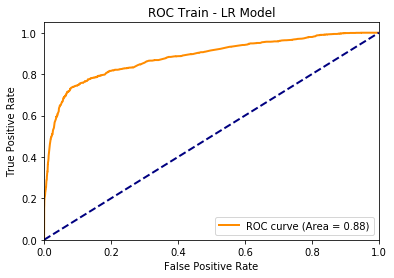

<Figure size 432x288 with 0 Axes>

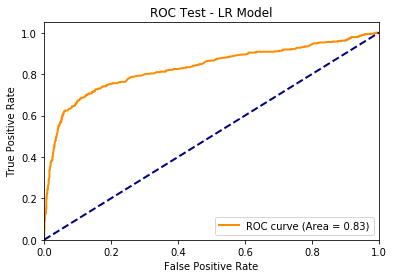

In [169]:
# Plotting the ROC curve
# import matplotlib.pyplot as plt
plotroc(fpr_train_LR, tpr_train_LR, 'ROC Train - LR Model')
plotroc(fpr_test_LR, tpr_test_LR, 'ROC Test - LR Model')

In [170]:
# KS table on Train data
ks_train = ks_table(y_train.values.flatten(), y_pred_prob_train.flatten(), n_groups=10, store=True)
ks_train

Max KS is 0.6296


,Group,Min Score,Max Score,Observations,Cum-Obs(%),Events,Cum-Events(%),Non-Events,Cum-Non-Events(%),Pred Event Rate(%),Act Event Rate(%),KS-Score
,,,,,,,,,,,,
9,1,0.748003,1.000000,834,0.0993,745,0.4049,89,0.0136,0.909957,0.893285,0.3913
8,2,0.358343,0.747611,843,0.1996,527,0.6913,316,0.0617,0.585902,0.625148,0.6296
7,3,0.149248,0.355306,843,0.3000,184,0.7913,659,0.1622,0.214798,0.218268,0.6291
6,4,0.100107,0.148813,776,0.3924,78,0.8337,698,0.2686,0.122635,0.100515,0.5651
5,5,0.085607,0.099719,901,0.4996,96,0.8859,805,0.3913,0.093153,0.106548,0.4946
4,6,0.074086,0.085382,834,0.5989,58,0.9174,776,0.5096,0.078289,0.069544,0.4078
3,7,0.065001,0.074051,849,0.7000,59,0.9495,790,0.6300,0.070000,0.069494,0.3195
2,8,0.051263,0.064943,812,0.7967,34,0.9679,778,0.7486,0.058503,0.041872,0.2193
1,9,0.033135,0.051254,868,0.9000,48,0.9940,820,0.8736,0.044627,0.055300,0.1204


In [171]:
# KS table on Test data
ks_test = ks_table(y_test.values.flatten(), y_pred_prob_test.flatten(), n_groups=10, store=True)
ks_test

Max KS is 0.5659


,Group,Min Score,Max Score,Observations,Cum-Obs(%),Events,Cum-Events(%),Non-Events,Cum-Non-Events(%),Pred Event Rate(%),Act Event Rate(%),KS-Score
,,,,,,,,,,,,
9,1,0.657909,0.999915,210,0.1000,176,0.3761,34,0.0208,0.833568,0.838095,0.3553
8,2,0.248809,0.656178,208,0.1990,120,0.6325,88,0.0748,0.488714,0.576923,0.5577
7,3,0.130675,0.248731,211,0.2995,50,0.7393,161,0.1734,0.179167,0.236967,0.5659
6,4,0.097443,0.130090,204,0.3967,25,0.7927,179,0.2831,0.110878,0.122549,0.5096
5,5,0.081549,0.097247,202,0.4929,15,0.8248,187,0.3977,0.090275,0.074257,0.4271
4,6,0.072187,0.081369,214,0.5948,23,0.8739,191,0.5147,0.076617,0.107477,0.3592
3,7,0.065233,0.071766,221,0.7000,16,0.9081,205,0.6403,0.069627,0.072398,0.2678
2,8,0.051373,0.065215,200,0.7952,9,0.9274,191,0.7574,0.058829,0.045000,0.1700
1,9,0.038427,0.051254,220,0.9000,15,0.9594,205,0.8830,0.047187,0.068182,0.0764


### Building a Gradient Boosting Machine model

In [177]:
# Since we have only ~50 features, we can get straight into hyperparameter tuning
# Since it is a tree-based model, we do not need to worry about intercorrelated features

# specify range of hyperparameters
param_grid = {
            'learning_rate' : np.arange(0.01, 0.26, 0.02), 
            'n_estimators' : range(100,701,200),
            'max_depth' : [3, 4]
            }

# set up Grid Search
model_cv = RandomizedSearchCV(estimator = GradientBoostingClassifier(), 
                                  param_distributions = param_grid, 
                                  n_iter=50, 
                                  random_state=42, 
                                  scoring= 'roc_auc', 
                                  cv = 3, 
                                  verbose = 0
                                 )

model_cv.fit(X_train_ce.values, y_train.values)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [178]:
# Fetching the best parameters in the GRID
print(model_cv.best_params_)

{'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.03}


In [179]:
# Saving the final model using pickle
with open(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\GBM_GRID.pkl', 'wb') as file:
    pickle.dump(model_cv, file)

In [ ]:
# code to load the model
with open(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\GBM_GRID.pkl', 'rb') as file:
        model_cv = pickle.load(file)

# Describing the loaded model
model_cv

In [180]:
gbmmodel = GradientBoostingClassifier(**model_cv.best_params_)
gbmmodel.fit(X_train_ce.values, y_train.values)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=700,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [181]:
# Saving the final model using pickle
with open(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\GBM_Model.pkl', 'wb') as file:
    pickle.dump(gbmmodel, file)

In [ ]:
# code to load the model
with open(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\GBM_Model.pkl', 'rb') as file:
        gbmmodel = pickle.load(file)

# Describing the loaded model
gbmmodel

<Figure size 432x288 with 0 Axes>

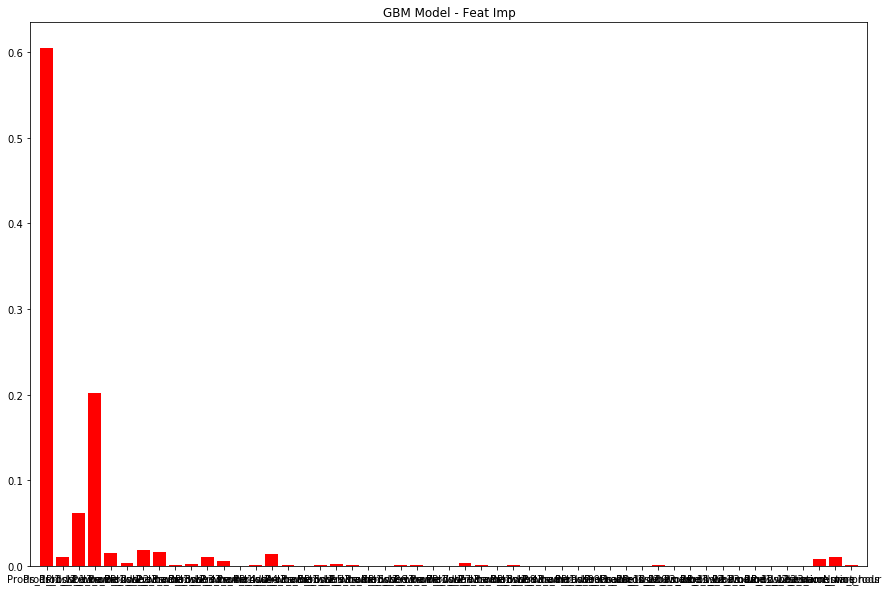

In [184]:
# Plotting Final Model's Feature importances
plotfeatimp(X_train_ce.columns.values, gbmmodel.feature_importances_, 'GBM Model - Feat Imp')

In [186]:
# Predictions on Train, Test Data
y_pred_train = gbmmodel.predict(X_train_ce.values)
y_pred_test  = gbmmodel.predict(X_test_ce.values)
y_pred_prob_train = np.array([x[1] for x in gbmmodel.predict_proba(X_train_ce.values)])
y_pred_prob_test  = np.array([x[1] for x in gbmmodel.predict_proba(X_test_ce.values)])

In [187]:
# Predictions on the unseen Test Data
y_pred_test_unseen  = gbmmodel.predict(X_test_unseen_ce.values)
y_pred_prob_test_unseen  = np.array([x[1] for x in gbmmodel.predict_proba(X_test_unseen_ce.values)])

temp_df = pd.DataFrame({'y_pred':y_pred_test_unseen, 'y_pred_prob':y_pred_prob_test_unseen}, index=X_test_unseen_ce_new.index)
temp_df.to_csv(r'C:\Users\abishek\Downloads\Pradeep\AV Hackathon (EComm)\GBM_model_test_pred.csv')

In [188]:
# Accuracy
accuracy_train_GBM = accuracy_score(y_pred_train,y_train.values)
accuracy_test_GBM = accuracy_score(y_pred_test,y_test.values)

# F1 score (a combined measure of precision & recall)
f1_train_GBM = f1_score(y_train.values, y_pred_train)
f1_test_GBM = f1_score(y_test.values, y_pred_test)

# AUC
fpr_train_GBM, tpr_train_GBM, _ = roc_curve(y_train.values, y_pred_prob_train)
fpr_test_GBM, tpr_test_GBM, _   = roc_curve(y_test.values, y_pred_prob_test)
auc_train_GBM = auc(fpr_train_GBM,tpr_train_GBM)
auc_test_GBM = auc(fpr_test_GBM,tpr_test_GBM)

# Confusion Matrix if needed
confusion_test_GBM = confusion_matrix(y_test, y_pred_test)
confusion_test_GBM

array([[1556,   76],
       [ 188,  280]], dtype=int64)

In [189]:
# 87% Accuracy
print("Train accuracy {}".format(accuracy_train_GBM))
print("Test accuracy is {}".format(accuracy_test_GBM))

# 68% F1 Score - A good improvement over the benchmark & in general, a good score
print("Train F1 score {}".format(f1_train_GBM))
print("Test F1 score is {}".format(f1_test_GBM))

# AUC of 84%
print('Train AUC is {}'.format(auc_train_GBM))
print('Test AUC is {}'.format(auc_test_GBM))

Train accuracy 0.9044047619047619
Test accuracy is 0.8742857142857143
Train F1 score 0.7640317367029092
Test F1 score is 0.6796116504854369
Train AUC is 0.9312512841330859
Test AUC is 0.8426161597117481


<Figure size 432x288 with 0 Axes>

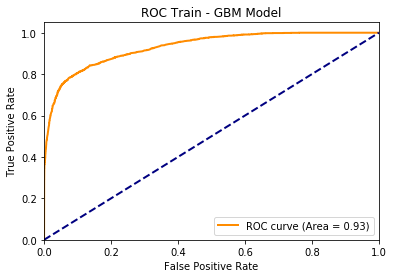

<Figure size 432x288 with 0 Axes>

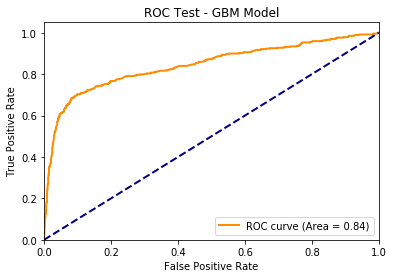

In [190]:
# Plotting the ROC curve
plotroc(fpr_train_GBM, tpr_train_GBM, 'ROC Train - GBM Model')
plotroc(fpr_test_GBM, tpr_test_GBM, 'ROC Test - GBM Model')

In [191]:
# KS table on Train data
ks_train = ks_table(y_train.values.flatten(), y_pred_prob_train.flatten(), n_groups=10, store=True)
ks_train

Max KS is 0.6975


,Group,Min Score,Max Score,Observations,Cum-Obs(%),Events,Cum-Events(%),Non-Events,Cum-Non-Events(%),Pred Event Rate(%),Act Event Rate(%),KS-Score
,,,,,,,,,,,,
9,1,0.804711,0.999107,836,0.0995,801,0.4353,35,0.0053,0.930418,0.958134,0.4300
8,2,0.380742,0.804654,844,0.2000,558,0.7386,286,0.0489,0.637351,0.661137,0.6897
7,3,0.154358,0.379194,839,0.2999,195,0.8446,644,0.1471,0.220048,0.232420,0.6975
6,4,0.103657,0.154146,841,0.4000,104,0.9011,737,0.2595,0.121039,0.123662,0.6416
5,5,0.093241,0.103619,833,0.4992,82,0.9457,751,0.3739,0.097011,0.098439,0.5718
4,6,0.068770,0.093194,847,0.6000,60,0.9783,787,0.4939,0.082561,0.070838,0.4844
3,7,0.044628,0.068729,839,0.6999,26,0.9924,813,0.6178,0.056653,0.030989,0.3746
2,8,0.016615,0.044541,840,0.7999,13,0.9995,827,0.7439,0.029713,0.015476,0.2556
1,9,0.008583,0.016563,837,0.8995,1,1.0000,836,0.8713,0.011875,0.001195,0.1287


In [192]:
# KS table on Test data
ks_test = ks_table(y_test.values.flatten(), y_pred_prob_test.flatten(), n_groups=10, store=True)
ks_test

Max KS is 0.5812


,Group,Min Score,Max Score,Observations,Cum-Obs(%),Events,Cum-Events(%),Non-Events,Cum-Non-Events(%),Pred Event Rate(%),Act Event Rate(%),KS-Score
,,,,,,,,,,,,
9,1,0.743111,0.998162,210,0.1000,176,0.3761,34,0.0208,0.880373,0.838095,0.3553
8,2,0.248513,0.739703,210,0.2000,129,0.6517,81,0.0705,0.551669,0.614286,0.5812
7,3,0.155141,0.245816,209,0.2995,44,0.7457,165,0.1716,0.193644,0.210526,0.5741
6,4,0.107395,0.154426,211,0.4000,24,0.7970,187,0.2862,0.124172,0.113744,0.5108
5,5,0.095267,0.107279,199,0.4948,18,0.8355,181,0.3971,0.100050,0.090452,0.4384
4,6,0.083671,0.095047,210,0.5948,22,0.8825,188,0.5123,0.091552,0.104762,0.3702
3,7,0.063216,0.083668,221,0.7000,16,0.9167,205,0.6379,0.072836,0.072398,0.2788
2,8,0.045357,0.062976,208,0.7990,9,0.9359,199,0.7598,0.052326,0.043269,0.1761
1,9,0.014256,0.045205,212,0.9000,19,0.9765,193,0.8781,0.031052,0.089623,0.0984


### Similarly, we can try any number of algorithms (RF, XGBoost, ANNs etc) to see which one fits best on the data